In [1]:
import sympy as sm
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

In [2]:
r, K, aC, eC, mC, aP, eP, mP = sm.symbols('r, K, a_C, e_C, m_C, a_P, e_P, m_P', positive=True)
R, C, P = sm.symbols('R, C, P', negative=False)
u, du = sm.symbols('u, du')

Rdt = r*R*(1 - (R/K)) - aC*R*C
Cdt = eC*aC*R*C - aP*C*P - mC*C
Pdt = eP*aP*C*P - mP*P

sm.Matrix([Rdt, Cdt, Pdt])

Matrix([
[      -C*R*a_C + R*r*(1 - R/K)],
[-C*P*a_P + C*R*a_C*e_C - C*m_C],
[           C*P*a_P*e_P - P*m_P]])

In [3]:
eqs = sm.solve([Rdt,Cdt,Pdt], R, C, P)

Ms = sm.Matrix([Rdt, Cdt, Pdt])
Msv = Ms.jacobian([R, C, P])
Msv


Matrix([
[-C*a_C + r*(1 - R/K) - R*r/K,                   -R*a_C,               0],
[                   C*a_C*e_C, -P*a_P + R*a_C*e_C - m_C,          -C*a_P],
[                           0,                P*a_P*e_P, C*a_P*e_P - m_P]])

In [4]:
MsvT = Msv[0] + Msv[4] + Msv[8]; MsvT
r1 =3.3; K1 = 15000; aC1 = 0.005; eC1 = 0.01; mC1 = 0.1; aP1 = 0.003; eP1 = 0.02; mP1 = 0.03
R1 = 10000; C1 = 800; P1 = 60
Trvl = MsvT.subs([(r,r1), (K,K1), (aC,aC1), (eC,eC1), (mC,mC1), (aP,aP1), (eP,eP1), (mP,mP1), (R,R1), (C,C1), (P,P1)])
Trvl


-4.86200000000000

In [5]:
Mpv = Ms.jacobian([r, K, aC, eC, mC, aP, eP, mP])
Mpv

Matrix([
[R*(1 - R/K), R**2*r/K**2,    -C*R,       0,  0,       0,       0,  0],
[          0,           0, C*R*e_C, C*R*a_C, -C,    -C*P,       0,  0],
[          0,           0,       0,       0,  0, C*P*e_P, C*P*a_P, -P]])

In [6]:
Mpv


Matrix([
[R*(1 - R/K), R**2*r/K**2,    -C*R,       0,  0,       0,       0,  0],
[          0,           0, C*R*e_C, C*R*a_C, -C,    -C*P,       0,  0],
[          0,           0,       0,       0,  0, C*P*e_P, C*P*a_P, -P]])

In [7]:
def TM3_linear(t, u, r, K, aC, eC, mC, aP, eP, mP) :
    du = np.zeros([36, 1])
    
    #variables
    R = u[0]
    C = u[1]
    P = u[2]
    
    
    #evolution of state variables
    du[0] = r*R*(1 - (R/K)) - aC*R*C
    du[1] = eC*aC*R*C - aP*C*P - mC*C
    du[2] = eP*aP*C*P - mP*P
    
    #Jacobian with respect to state variables
    Jx = np.array([[-C*aC + r*(1 - (R/K)) - R*(r/K), -R*aC, 0],[C*aC*eC, -P*aP + R*aC*eC - mC, -C*aP],[0, P*aP*eP, C*aP*eP - mP]])
    Dx0 = u[np.arange(3, 3+9)].reshape(3,3)

    dDx0 = (np.matmul(Jx,Dx0))
    dDxv0 = dDx0.reshape(9, 1)
    du[np.arange(3,3+9)] = dDxv0
    
    #Jacobian with respect to parameters
    Jalpha0 = np.array([R*(1 - (R/K)), R**2*(r/K**2), -C*R, 0, 0, 0, 0, 0]).reshape(1,8)
    Jalpha1 = np.array([0, 0, C*R*eC, C*R*aC, -C, -C*P, 0, 0]).reshape(1,8)
    Jalpha2 = np.array([[0, 0, 0, 0, 0, C*P*eP, C*P*aP, -P]]).reshape(1,8)
    Jalpha = np.concatenate((Jalpha0, Jalpha1, Jalpha2), axis=0)
    

    Dalpha = u[np.arange(12, 12+24)].reshape(3,8)
    dDalpha = (np.matmul(Jx,Dalpha) + Jalpha);
    dDalphav = dDalpha.reshape(24,1)
    du[np.arange(12,12+24)] = dDalphav
    du = du.reshape(36,)
    return(du)


In [8]:
r =2.5; K = 15000; aC = 0.0005; eC = 0.008; mC = 0.001; aP = 0.001; eP = 0.02; mP = 0.03

Cnd0 = K*aC*eC - mC
Cnd1 = 1 - ((aC*mP)/(aP*eP*r))
Cnd2 = K*eC*Cnd1 - (mC/aP)

print([Cnd0, Cnd1, Cnd2])



[0.059, 0.7, 83.0]


In [9]:
from scipy.integrate import solve_ivp
p = (r, K, aC, eC, mC, aP, eP, mP)

u0 = np.concatenate(([12000, 3998, 402], np.eye(3).reshape(9), np.zeros(24)), axis=0)
t_span = (0.0, 10000.0)
tint = np.linspace(0, 1000, 10000)
sol1 = solve_ivp (TM3_linear, t_span, u0, args = p, t_eval = tint)

print(np.shape(sol1.y))
print(np.shape(sol1.t))

(36, 10000)
(10000,)


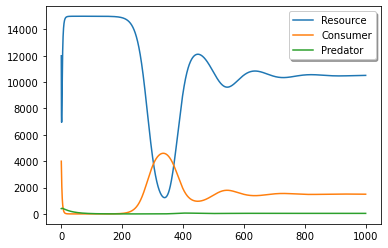

In [10]:
R = sol1.y[0,:].T.reshape(len(sol1.y[0,:]),1);
C = sol1.y[1,:].T.reshape(len(sol1.y[1,:]),1);
P = sol1.y[2,:].T.reshape(len(sol1.y[2,:]),1);

T = sol1.t
sv = np.concatenate([R, C, P], axis=1)
#plt.yscale("log") 
plt.plot(T, sv)
plt.legend(['Resource', 'Consumer', 'Predator'], shadow=True)
plt.show()

In [11]:
R[9990:10000]

array([[10512.00673989],
       [10512.01661399],
       [10512.02628837],
       [10512.03583715],
       [10512.04534758],
       [10512.05492007],
       [10512.06466815],
       [10512.07466401],
       [10512.08465419],
       [10512.09452736]])

In [12]:
##Lyapunov exponents
Dxv = (sol1.y[np.arange(3,3+9),:]).T
Ts = np.shape(Dxv)[0]

lmbda = np.empty([Ts,3])*np.nan; Nexpx0 = np.empty(Ts)*np.nan;

for i in np.arange(Ts):
    Dxi = Dxv[i,:].reshape(3,3)
    Mi = np.matmul(Dxi.T, Dxi)
    
    
    Mi1 = np.count_nonzero(Mi == np.inf)
    Mi2 = np.count_nonzero(Mi == np.nan)
    Mii = Mi1 + Mi2
    
    if Mii == 0:
        Uxi,Lxi,Vxi = np.linalg.svd(Mi, full_matrices=True)
        Ldxi = np.diag(Lxi);

        ti = tint[i];
        lambdai = np.log(Lxi)/(2*ti)
        Nexpx0i = len(lambdai[lambdai > 0])

        lmbda[i,:] = lambdai
        Nexpx0[i] = Nexpx0i

/home/karthik/anaconda3/envs/gee/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: invalid value encountered in true_divide


In [13]:
Nexpx0

array([0., 1., 1., ..., 0., 0., 0.])

In [14]:
i=10000-100
Dxi = Dxv[i,:].reshape(3,3)
Mi = np.matmul(Dxi.T, Dxi)
    
Mi1 = np.count_nonzero(Mi == np.inf)
Mi2 = np.count_nonzero(Mi == np.nan)
Mii = Mi1 + Mi2
    
if Mii == 0:
    Uxi,Lxi,Vxi = np.linalg.svd(Mi, full_matrices=True)
    Ldxi = np.diag(Lxi);

    ti = tint[i];
    lambdai = np.log(Lxi)/(2*ti)
    Nexpx0i = len(lambdai[lambdai > 0])

    lmbda[i,:] = lambdai
    Nexpx0[i] = Nexpx0i



In [15]:
i=10000-100
lmbda[i]

array([-0.00158534, -0.01817035, -0.02899417])

In [164]:
lmbda[np.min(np.where(Nexpx0[1:(np.shape(Nexpx0)[0])] == 0))]
#R[np.min(np.where(Nexpx0[1:(np.shape(Nexpx0)[0])] == 0))]
C[np.min(np.where(Nexpx0[1:(np.shape(Nexpx0)[0])] == 0))]
#P[np.min(np.where(Nexpx0[1:(np.shape(Nexpx0)[0])] == 0))]
#np.min(np.where(Nexpx0[1:(np.shape(Nexpx0)[0])] == 0))
C[8000]

array([1484.28661139])

In [16]:
##Observability
Dalphav = (sol1.y[np.arange(12,12+24),:]).T
mu = np.zeros([Ts,8])*np.nan; Nexpalpha = np.zeros(Ts)*np.nan;

for i in np.arange(Ts):
    
    Dalphai = Dalphav[i,:].reshape(3,8)
    Pi = np.matmul(Dalphai.T, Dalphai)
    
    Pi1 = np.count_nonzero(Pi == np.inf)
    Pi2 = np.count_nonzero(Pi == np.nan)
    Pii = Pi1 + Pi2
    

    if Pii == 0:
    
        Ualphai,Lalphai,Valphai = np.linalg.svd(Pi, full_matrices=True);

        ti = tint[i];
        mui = np.log(Lalphai)/(2*ti)
        Nexpalphai = len(mui[mui > 0])

        mu[i,:] = mui
        Nexpalpha[i] = Nexpalphai
        
        


/home/karthik/anaconda3/envs/gee/lib/python3.7/site-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in log


In [17]:
mu[9900,]

array([ 0.01629372,  0.01425562,  0.00873548, -0.00439128, -0.00490879,
       -0.00577109, -0.00778807, -0.0093882 ])

In [62]:
a1 = np.array(np.meshgrid(np.arange(10), np.arange(10), np.linspace(0,19,10)))
a2 = (a1.reshape(1000, 3))
a2[0]
#np.linspace(0,19,20)

array([0., 0., 0.])

import sympy as sm
a,b,c,d,e = sm.symbols('a,b,c,d,e', positive = True)

In [194]:
import sympy as sm
a,b,c,d,e, l = sm.symbols('a,b,c,d,e,lambda')
J5 = sm.Matrix([[-a, -b, 0],[c, 0, -d],[0, e, 0]])
J50 = J5 - l*sm.eye(3)
eq1 = J50.det()
sl = sm.solve(eq1, l)
#sl[0]
#eq1*-1

-a/3 - (a**2 - 3*b*c - 3*d*e)/(3*(a**3 + 27*a*d*e/2 - 9*a*(b*c + d*e)/2 + sqrt(-4*(a**2 - 3*b*c - 3*d*e)**3 + (2*a**3 + 27*a*d*e - 9*a*(b*c + d*e))**2)/2)**(1/3)) - (a**3 + 27*a*d*e/2 - 9*a*(b*c + d*e)/2 + sqrt(-4*(a**2 - 3*b*c - 3*d*e)**3 + (2*a**3 + 27*a*d*e - 9*a*(b*c + d*e))**2)/2)**(1/3)/3

-a/3 - (a**2 - 3*b*c - 3*d*e)/(3*(a**3 + 27*a*d*e/2 - 9*a*(b*c + d*e)/2 + sqrt(-4*(a**2 - 3*b*c - 3*d*e)**3 + (2*a**3 + 27*a*d*e - 9*a*(b*c + d*e))**2)/2)**(1/3)) - (a**3 + 27*a*d*e/2 - 9*a*(b*c + d*e)/2 + sqrt(-4*(a**2 - 3*b*c - 3*d*e)**3 + (2*a**3 + 27*a*d*e - 9*a*(b*c + d*e))**2)/2)**(1/3)/3